In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import util
import numpy as np
import pandas as pd
#from sklearn.metrics import accuracy_score

# Specify data folder
data_folder = '../data'

# A Case Study for Moving Targets

## A Case Study for Moving Targets

**Let's consider a more practical use case for MT**

We will still tackle a synthetic problem, but one closer to practice

* In particular, given a classification problem
* We will require to have roughly balance class predictions

$$
\left| \sum_{i = 1}^{m} z_{ij} - \frac{m}{n_c} \right| \leq \beta \frac{m}{n_c}, \quad \forall j \in 1..n_c
$$

* Where $z_{ij} = 1$ iff the classifier predicts class $j$ for example $i$
* I.e. the result of an argmax applied to the output of a probabilistic classifier

**...Basically, this the "very bad example" from the previous section**

## The Dataset 

**We will use the ["wine quality" dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from UCI**

In [6]:
data = util.load_classification_dataset(f'{data_folder}/winequality-white.csv', onehot_inputs=['quality'])
display(data.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,0,0,1,0,0,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,0,0,1,0,0,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0,0,1,0,0,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0


* We will learn a model to predict wine quality
* There are 7 possible classes, represented via a one-hot encoding
* An ordinal encoding would be better, but our choice makes for a better example

## The Dataset

**We perform pre-processing as usual**

In [7]:
dtout = [c for c in data.columns if c.startswith('quality_')]
dtin = [c for c in data.columns if c not in dtout]
trl, tsl, scalers = util.split_datasets([data], fraction=0.7, seed=42, standardize=dtin)
tr, ts, scaler = trl[0], tsl[0], scalers[0]
tr.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
count,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1.469000e+03,1469.000000,1469.000000,1469.000000,1469.000000,1469.000000,1469.000000,1469.0
mean,5.235960e-16,1.475259e-16,-1.934766e-16,1.644551e-16,-1.015752e-16,-1.813843e-16,1.463167e-16,-8.416231e-15,-4.198442e-15,3.337471e-16,7.255372e-17,0.004765,0.027229,0.289993,0.454731,0.189925,0.033356,0.0
std,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,0.068889,0.162807,0.453913,0.498116,0.392375,0.179626,0.0
min,-3.513954e+00,-1.981296e+00,-2.750607e+00,-1.170902e+00,-1.436585e+00,-1.916670e+00,-2.969922e+00,-2.338980e+00,-2.511541e+00,-2.086077e+00,-2.046688e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-6.396233e-01,-6.660564e-01,-5.421591e-01,-9.256225e-01,-4.519909e-01,-6.550002e-01,-7.262526e-01,-7.862395e-01,-6.881092e-01,-7.002723e-01,-8.300787e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,-4.080447e-02,-1.601951e-01,-1.331873e-01,-2.306630e-01,-1.387109e-01,-8.151391e-02,-1.309932e-01,-5.839245e-02,-1.020061e-01,-9.398282e-02,-1.001133e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,5.580144e-01,4.468384e-01,4.393732e-01,7.197965e-01,1.745692e-01,5.493210e-01,6.474229e-01,7.387734e-01,5.492195e-01,5.123066e-01,7.109594e-01,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,8.821714e+00,4.898418e+00,5.347035e+00,4.031074e+00,1.006527e+01,1.454239e+01,6.897646e+00,3.112941e+00,4.065838e+00,5.102784e+00,2.819749e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## Dataset Balance

**We can use the (avg. of) our constraint metric to assess the dataset balance:**

$$
\frac{1}{n_c} \sum_{j=1}^{n_c} \left| \sum_{i = 1}^{m} \hat{z}_{ij} - \frac{m}{n_c} \right|, \quad \forall j \in 1..n_c
$$

* Where $\hat{z}$ are the class columns (one-hot encoding)

In [8]:
bal_thr = 0.2
tr_true = np.argmax(tr[dtout].values, axis=1)
ts_true = np.argmax(ts[dtout].values, axis=1)
tr_bal_src = util.avg_bal_deviation(tr_true, bal_thr, nclasses=len(dtout))
ts_bal_src = util.avg_bal_deviation(ts_true, bal_thr, nclasses=len(dtout))
print(f'Original avg deviation: {tr_bal_src*100:.2f}% (training), {ts_bal_src*100:.2f}% (test)')

Original avg deviation: 101.42% (training), 98.71% (test)


* Our goal will be to push the balance deviation down to 20%
* I.e. we will assume $\beta = 0.2$ in the constraint

## The Learner

**Our "learner" will be a multilayer perceptron**

The code can be found as usual in the `util` module

```python
class MLPLearner(object):
    def __init__(self, hidden, epochs=20, batch_size=32,
            epochs_fine_tuning=None, verbose=0): ...

    def fit(self, X, y): ...

    def predict_proba(self, X): ...

    def predict(self, X): ...
```

* We are using a standard scikit-learn API
* ...With the ability to use different \#epochs for the first and subsequent training
* ...Which will prove useful later

## The Learner

**Let's start by checking how regular training fares**

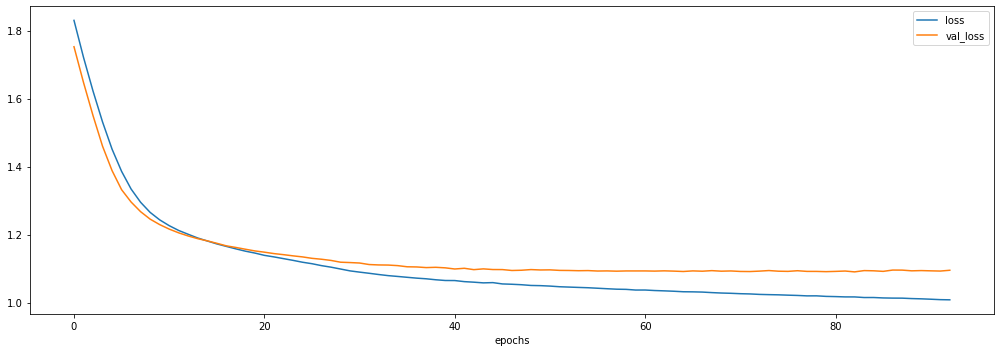

Model loss: 1.0167 (training) 1.0904 (validation)


In [10]:
hidden = [8, 8]
learner = util.MLPLearner(hidden=hidden, epochs=150)
learner.fit(tr[dtin].values, tr[dtout].values)
util.plot_training_history(learner.history, figsize=figsize)

## The Learner

**Now we can check the model performance**

...In terms of both accuracy and degree of constraint violation

In [11]:
tr_pred_prob = learner.predict_proba(tr[dtin])
ts_pred_prob = learner.predict_proba(ts[dtin])
tr_acc, tr_bal = util.mt_balance_stats(tr[dtout].values, tr_pred_prob, bal_thr)
ts_acc, ts_bal = util.mt_balance_stats(ts[dtout].values, ts_pred_prob, bal_thr)
print(f'Accuracy: {tr_acc:.2f} (training), {ts_acc:.2f} (test)')
print(f'Classifier avg deviation: {tr_bal*100:.0f}% (training), {ts_bal*100:.0f}% (test)')
print(f'Balance violation threshold: {bal_thr*100:.0f}%')

Accuracy: 0.55 (training), 0.53 (test)
Classifier avg deviation: 133% (training), 132% (test)
Balance violation threshold: 20%


* The accuracy is slightly above 50%
* ...But the balance violation is far larger than our threshold

## The Master

**The master step is implemented via an Or-tools model**

```python
def mt_balance_master(y_true, y_pred, bal_thr, alpha=1, time_limit=None, mode=...):
    # Build a model
    slv = pywraplp.Solver.CreateSolver('CBC')
    ...
    # Solve
    status = slv.Solve()
    ...
    # Return the solution and stats
    return sol, stats
```

* `y_true` corresponds to $\hat{y}$ and `y_pred` to the current prediction vector
* The balance threshold `bal_thr` is a fractional value
* A mode parameter allows one to adjust a bit the problem behavior

## The Master

**The master step is implemented via an Or-tools model**

```python
def mt_balance_master(y_true, y_pred, bal_thr, alpha=1, time_limit=None, mode='gradient'):
    ...
    # Build target variables
    z = {(i,j) : slv.IntVar(0, 1, f'z[{i},{j}]') for i in range(ns) for j in range(nc)}
    # Unique class constraints
    for i in range(ns):
        slv.Add(sum(z[i, j] for j in range(nc)) == 1)
    ...
```

* We are using integer variables for the targets
* This is partly for sake of simplicity and scalability
* ...And partly since it is compatible with DT models as well
* Using continuous (probabilistic) targets is possible, but harder

## The Master

**The master step is implemented via an Or-tools model**

```python
def mt_balance_master(y_true, y_pred, bal_thr, alpha=1, time_limit=None, mode='gradient'):
    ...
    # Add the balance constraint
    ref = ns / nc
    for j in range(nc):
        slv.Add(sum(z[i, j] for i in range(ns)) <= ref + ref * bal_thr)
        slv.Add(sum(z[i, j] for i in range(ns)) >= ref - ref * bal_thr)
    ...
```

* The balance constraint is implemented via two inequalities
* Class counts are easy to compute by relying on integer one-hot targets

## The Master

**The master step is implemented via an Or-tools model**

```python
def mt_balance_master(y_true, y_pred, bal_thr, alpha=1, time_limit=None, mode='gradient'):
    ...
    # Build the gradient-based part of the objective
    loss_t = 0
    for i in range(ns):
        for j in range(nc):
            loss_t += 0.5 * dsgn(y_pred[i, j], y_true[i, j]) * (z[i, j]-y_pred[i, j])
    ...
```

* As a loss $L$ for the master, we use $\|y - \hat{y}\|$
* ...Hence the gradient is given by the sign of the difference $y - \hat{y}$
* If $y_i = \hat{y}_i$ for some $i$, the `dsgn` function has a customized behavior 

## The Master

**The master step is implemented via an Or-tools model**

```python
def mt_balance_master(y_true, y_pred, bal_thr, alpha=1, time_limit=None, mode='gradient'):
    ...
    # Build the quadratic part of the objective
    loss_p = 0
    for i in range(ns):
        for j in range(nc):
            loss_p += z[i, j] * (1-y_pred[i, j])**2 + (1-z[i, j]) * (0-y_pred[i, j])**2
    # Define the cost function
    slv.Minimize(alpha * loss_t + loss_p)
    ...
```

* The quadratic part of the objective is easy to linearize
* ...Since we are using integer $z$ variables 

## Loss-driven Projection

**A simpler approach to inject constraints in the ML model...**

...Starts by directly "projecting" the ground truth $\hat{y}$ in feasible space

* The projection can be done using the loss itself as a distance:

$$
\text{argmin}_{z} \left\{ L(z, \hat{y}) \mid z \in C \right\}
$$

**By doing this, we can obtain the _best possible_ feasible target vector**

In [12]:
zp, stats = util.mt_balance_master(tr[dtout].values, tr[dtout].values, bal_thr, time_limit=10, mode='projection')
tmp_acc, tmp_bal = util.mt_balance_stats(tr[dtout].values, zp, bal_thr)
print(f'Accuracy: {tmp_acc:.2f}, Balance deviation: {tmp_bal*100:.2f}%, Optimal solution: {stats["opt"]}')

Accuracy: 0.58, Balance deviation: 16.80%, Optimal solution: False


* In our case, the solution is not optimal (there is a time limit)
* ...But it's very close to optimality

## Loss-driven Projection

**Then, the simple approach consists training against this "ideal" vector**

The method is implemented in `util` as part of the MT code:

In [13]:
learner_prj = util.MLPLearner(hidden=hidden, epochs=600)
util.mt_balance(tr[dtin].values, tr[dtout].values, learner_prj, bal_thr, mode='projection', master_tlim=10);
tr_pred_prob = learner_prj.predict_proba(tr[dtin])
ts_pred_prob = learner_prj.predict_proba(ts[dtin])
tr_acc, tr_bal = util.mt_balance_stats(tr[dtout].values, tr_pred_prob, bal_thr)
ts_acc, ts_bal = util.mt_balance_stats(ts[dtout].values, ts_pred_prob, bal_thr)
print(f'Accuracy: {tr_acc:.2f} (training), {ts_acc:.2f} (test)')
print(f'Classifier balance violation: {tr_bal*100:.0f}% (training), {ts_bal*100:.0f}% (test)')

Accuracy: 0.44 (training), 0.43 (test)
Classifier balance violation: 103% (training), 103% (test)


* The accuracy is lower, since we have confounded the input/output relation
* ...And the violation is roughly the same!
  - The ML model bias prevents it from reaching the adjusted target
  - ...But too little bias may result in overfitting

## Moving Targets

**Let's now test the actual MT method**

We use fewer training epochs after the first `fit` call to speed up the process

In [14]:
alpha, max_iter = 5, 10
epochs, epochs_fine_tuning = 150, 30
learner_mt = util.MLPLearner(hidden=hidden, epochs=epochs, epochs_fine_tuning=epochs_fine_tuning)
util.mt_balance(tr[dtin].values, tr[dtout].values, learner_mt, bal_thr, alpha,
                max_iter, master_tlim=1, verbose=1);

(#1) l-acc: 0.37, l-bal: 0.47, l-time: 1.29s, m-acc: 0.58, l-m dist: 3.02, m-time: 1.55s
(#2) l-acc: 0.34, l-bal: 0.21, l-time: 1.25s, m-acc: 0.58, l-m dist: 2.91, m-time: 1.40s
(#3) l-acc: 0.34, l-bal: 0.19, l-time: 1.11s, m-acc: 0.57, l-m dist: 2.90, m-time: 1.39s
(#4) l-acc: 0.34, l-bal: 0.18, l-time: 1.12s, m-acc: 0.54, l-m dist: 2.96, m-time: 1.53s
(#5) l-acc: 0.35, l-bal: 0.18, l-time: 1.31s, m-acc: 0.48, l-m dist: 3.03, m-time: 1.39s
(#6) l-acc: 0.35, l-bal: 0.19, l-time: 1.30s, m-acc: 0.43, l-m dist: 3.10, m-time: 1.50s
(#7) l-acc: 0.35, l-bal: 0.18, l-time: 1.13s, m-acc: 0.40, l-m dist: 3.14, m-time: 1.57s
(#8) l-acc: 0.36, l-bal: 0.18, l-time: 1.11s, m-acc: 0.38, l-m dist: 3.17, m-time: 1.43s
(#9) l-acc: 0.36, l-bal: 0.17, l-time: 1.27s, m-acc: 0.37, l-m dist: 3.19, m-time: 1.42s
(#10) l-acc: 0.36, l-bal: 0.18, l-time: 1.11s, m-acc: 0.37, l-m dist: 3.20, m-time: 1.40s


* Constraint satisfaction improves across iterations
* The learner/master accuracy tends to decrease/increase

## Moving Targets

**Let's check generalization over the test set**

In [15]:
tr_pred_prob = learner_mt.predict_proba(tr[dtin])
ts_pred_prob = learner_mt.predict_proba(ts[dtin])
tr_acc, tr_bal = util.mt_balance_stats(tr[dtout].values, tr_pred_prob, bal_thr)
ts_acc, ts_bal = util.mt_balance_stats(ts[dtout].values, ts_pred_prob, bal_thr)
print(f'Accuracy: {tr_acc:.2f} (training), {ts_acc:.2f} (test)')
print(f'Classifier balance deviation: {tr_bal*100:.0f}% (training), {ts_bal*100:.0f}% (test)')

Accuracy: 0.36 (training), 0.29 (test)
Classifier balance deviation: 18% (training), 12% (test)


We do have some overfitting in terms of accuracy

* This is due to the fact that we have very restrictive constraints
* ...And they directly oppose information in the data

Constraint satisfaction generalizes without issues

* ...And this is a big deal!